In [5]:
import sys,re
from modeller import *
from modeller.scripts import complete_pdb
from domutil.util import *
import StringIO

with stdoutIO() as s:
    env = environ()
    env.io.atom_files_directory = ['../pdbs','$(PDBlib)/../../dompdb']
    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')

    
    
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
test = 0;

In [6]:
def MAD_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if not isinstance(points,np.ndarray):
        points = np.array(points)
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [7]:
import numpy as np
from .models import *
import json
### Lets get 2.40.50.140
def select_homsf(sc):
#     sc = "2.40.50.140".split('.');
    sclst = sc.split('.');
    hier = ["Class","arch","topo","homsf","s35","s60","s95","s100"]
    dct = {x:int(y) for x,y in zip(hier,sclst+['0'])}
    # x for x in 
    homsf = classification.objects.get(**dct)
    return homsf


# s0 = StringIO.StringIO();
def preprocess(sfname="2.40.50.140"):
    homsf = select_homsf(sfname);

    xs = [];
    ys = [];
    y2s= [];
    lbls =[];


    for d in homsf.classification_set.all():      
        d = d.domain_set.all()[0]
        vals = get_something( str(d.domain_id),env,s0=s0)
        x = vals['num_nb_pair']
        y = vals['DOPE']
        xs += [x];
        ys += [y];
        y2s+= [d.domain_length]
        lbls+=[d.domain_id];

    return (np.array(xs),np.array(ys),np.array(y2s),lbls)
    
#### The ACTUAL functoinal scripts!!!
import mpld3
import matplotlib as mpl
mpl.use('Agg')

import matplotlib.pyplot as plt

import sys,re
from domutil.util import *
from modeller import *
from modeller.scripts import complete_pdb
import StringIO

with stdoutIO() as s:
    env = environ()
    env.io.atom_files_directory = ['../pdbs','$(PDBlib)/../../dompdb']
    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')
s0=StringIO.StringIO()
# import StringIO# import 
# from mpld3 import *
# from mpld3 import utils


class HelloWorld(mpld3.plugins.PluginBase):  # inherit from PluginBase
    """Hello World plugin"""
    
    JAVASCRIPT = """
    mpld3.register_plugin("helloworld", HelloWorld);
    HelloWorld.prototype = Object.create(mpld3.Plugin.prototype);
    HelloWorld.prototype.constructor = HelloWorld;
    HelloWorld.prototype.requiredProps = ["id","labels",];
    
    function HelloWorld(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };
    
    HelloWorld.prototype.draw = function(){
       
            
        var obj = mpld3.get_element(this.props.id);
        var labels = (this.props.labels);
        
        obj.elements().on("mousedown",
                          function(d, i){
                          alert("clicked on points[" + labels[i] + "]");
                          //highlight("#row_264173");
                          highlight("#dbid_"+labels[i]);
                          });
    }
    """
    def __init__(self, points,labels):
        self.dict_ = {"type": "helloworld",
                     "id": mpld3.utils.get_id(points),
                     "labels":labels}
        
def scatterplot_json(sfname='1.10.30.10'):
    msg = '';
    plt.close()
    siz = [400,400]
    DPI=100.
    fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
    # fig.tight_layout()

    # DPI = fig.get_dpi()
    # fig.set_size_inches(400.0/float(DPI),400.0/float(DPI))    

    ax1 = fig.add_subplot(111)


    pdata = preprocess(sfname);

    ### preprocess() returns a tuple of shape (nonbonded_pair_nums, DOPE, domain_length,  domian_id)
    if not pdata:
        y2s,ys,xs,lbls = preprocess(sfname)
    else:
        y2s,ys,xs,lbls = pdata

    ax1.set_xlim([0,500])
    ax1.set_ylim([0,800E3])
    ax1.set_xlabel('Domain length (aa)')
    ax1.set_ylabel('Number nb-interaction pairs')


    ids=[];
    for d in select_homsf(sfname).classification_set.all():
        ids.append((d.domain_set.all()[0].id))

    # points = ax1.scatter(xs,y2s,s=33,marker = 'x',)
    # points = ax1.scatter(xs,y2s,s=30,marker = 'o',color = 'g')
    points = ax1.scatter(xs,y2s,edgecolor = 'b',facecolor = 'none',
        marker ='o',
         s =30)


    try:
        # ((m,b),C) = np.polyfit(xs, y2s, 1, cov =True) ### This covariance seems different from the one generated by np.cov()
        (m,b) = np.polyfit(xs, y2s, 1, cov = False)
        C = np.cov(xs,y2s)
        r_sq = cov2corr(C).flat[1] ** 2
    except Exception as err:
        m = 0.
        b = 0.
        r_sq = 0
        msg += '\nErr:' + str(err);
    res2  = y2s - ( m*xs + b)
    outs = MAD_outlier(res2,3.0)
    outs = outs * (res2<0);
    xso = xs[outs]
    y2so = y2s[outs]
    sc1 = ax1.scatter(xso,y2so,s=33,
        color='r',
        marker = 'x',
        label='outlier num = %d'%sum(outs))

    # title = '''
    # $y  = %s \\cdot x + %s$ \n
    # $R^{2}=%3.3f $'''% (latex_float(m,4),latex_float(b,4),r_sq)

    title = '''
    y  = %5.3f * x + %5.3f 
    R_squared=%3.3f '''% (m,b,r_sq)
    xmm = np.array([min(xs),max(xs)])
    ax1.plot(xmm, m*xmm + b, 'g--',label = 'linear regression fit')

    ax1.legend()

    title +=msg;
    ax1.set_title(
        title)

    tooltip = mpld3.plugins.PointLabelTooltip(points, labels=lbls)
    mpld3.plugins.connect(fig, tooltip)
    mpld3.plugins.connect(fig, HelloWorld(points,ids))
    jdict = mpld3.fig_to_dict(fig);
    jstr = json.dumps(jdict);
    # fig.show()
    # plt.close("all")
#     mpld3.show()
    return([jdict,msg])


# mpld3.save_json(fig,'tmp')

In [4]:
    
#     pdata = preprocess()

#     homsf = select_homsf("2.40.50.140");
#     dlist = [];
#     for dclass in homsf.classification_set.all():
#     #     print()
#         d = dclass.domain_set.all()[0]
#         dlist += [d];



#     d = dlist[0]
#     d.domain_id
#     vals = get_something( str(d.domain_id),env,s0=s0)
#     x = vals['num_nb_pair']
#     y = vals['DOPE']
#     # x

#     xs = [];
#     ys = [];
#     lbls =[];
#     s0 = StringIO.StringIO();
#     for d in dlist:
#         vals = get_something( str(d.domain_id),env,s0=s0)
#         x = vals['num_nb_pair']
#         y = vals['DOPE']
#         xs += [x];
#         ys += [y];
#         lbls+=[d.domain_id];
#     return (np.array(xs),np.array(ys),lbls)
if test:
    pdata = preprocess()

    homsf = select_homsf("2.40.50.140");
    dlist = [];
    for dclass in homsf.classification_set.all():
    #     print()
        d = dclass.domain_set.all()[0]
        dlist += [d];



    d = dlist[0]
    d.domain_id
    vals = get_something( str(d.domain_id),env,s0=s0)
    x = vals['num_nb_pair']
    y = vals['DOPE']
    # x

    xs = [];
    ys = [];
    lbls =[];
    s0 = StringIO.StringIO();
    for d in dlist:
        vals = get_something( str(d.domain_id),env,s0=s0)
        x = vals['num_nb_pair']
        y = vals['DOPE']
        xs += [x];
        ys += [y];
        lbls+=[d.domain_id];
    

In [5]:
# sfname = "1.10.10.60"

# plt.close("all")
# fig = plt.figure(figsize = [16,16])
# ax1 = fig.add_subplot(111)

# xs,ys,lbls = preprocess(sfname)
# ax1.scatter(xs,ys,s=10,marker = 'x',)

# for x,y,label in zip(xs,ys,lbls):
#     ax1.annotate(label,xy=(x,y))

# ((m,b),C) = np.polyfit(xs, ys, 1, cov =True)
# r_sq = cov2corr(C).flat[1] ** 2

# ax1.plot(xs, m*xs + b, 'r-')
# ax1.set_title('$ superfamily %s \n  R^{2}=%3.3f $' % (sfname,r_sq))

In [8]:
def cov2corr(c):
    c = np.copy(c)
    try:
        d = np.diag(c)
    except ValueError:
        # scalar covariance
        # nan if incorrect value (nan, inf, 0), 1 otherwise
        return c / c
    stddev = np.sqrt(d.real)
    c /= stddev[:, None]
    c /= stddev[None, :]

    # Clip real and imaginary parts to [-1, 1].  This does not guarantee
    # abs(a[i,j]) <= 1 for complex arrays, but is the best we can do without
    # excessive work.
    np.clip(c.real, -1, 1, out=c.real)
    if np.iscomplexobj(c):
        np.clip(c.imag, -1, 1, out=c.imag)

    return c
# cov2corr(C)

def latex_float(f,n=3):
    float_str = "{0:.{1:d}E}".format(f,n)
    if "E" in float_str:
        base, exponent = float_str.split("E")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
    

In [6]:
def scatter_p1(sfname="1.10.10.60",pdata = None):
    plt.close("all")
    fig = plt.figure(figsize = [16,16])
    ax1 = fig.add_subplot(111)
    ax1b = ax1.twinx()
    ax1.set_xlim([1,300e3])
    ax1.set_ylim([-30e3,-1])    
    ax1.set_xlabel('non-boned interaction pair_nums')
    ax1.set_ylabel('raw DOPE energy') 
    
    if not pdata:
        xs,ys,y2s,lbls = preprocess(sfname)
    else:
        xs,ys,y2s,lbls = pdata
    #     ys = -ys
    # xs
    ax1.scatter(xs,ys,s=10,marker = 'x',)
    points = ax1b.scatter(xs,y2s,s=30,marker = 'o',color = 'g')

    for x,y,label in zip(xs,ys,lbls):
        ax1.annotate(label,xy=(x,y))
    for x,y,label in zip(xs,y2s,lbls):
        ax1b.annotate(label,xy=(x,y))
        
    ((m,b),C) = np.polyfit(xs, ys, 1, cov =True)
    r_sq = cov2corr(C).flat[1] ** 2

    title = r'''$ superfamily: %s $ 
          red: $y  = %s \cdot x + %s $
          $R^{2}=%3.3f $'''% (sfname,latex_float(m,4),latex_float(b,4),r_sq)
    # ax1.plot(x, y, '.')
    ax1.plot(xs, m*xs + b, 'r-')


    ((m,b),C) = np.polyfit(xs, y2s, 1, cov =True)
    r_sq = cov2corr(C).flat[1] ** 2
    title += r'''
    green: $y  = %s \cdot x + %s $
    $R^{2}=%3.3f $'''% (latex_float(m,4),latex_float(b,4),r_sq)
    ax1b.plot(xs, m*xs + b, 'g-')

    ax1.set_title(
        title)

    return ((fig,points))


    
#     ax1.set_xscale("log")
#     ax1.set_yscale("log")

print ('hi1')
s0=StringIO.StringIO()
print('hi2')
# pdata = preprocess()
print('hi3')

hi1
hi2
hi3


In [7]:
sfname = '1.10.238.10'
homsf = select_homsf(sfname);

xs = [];
ys = [];
y2s= [];
lbls =[];



for d in homsf.classification_set.all():
    d = d.domain_set.all()[0]
    vals = get_something( str(d.domain_id),env,s0=s0)
    x = vals['num_nb_pair']
    y = vals['DOPE']
    xs += [x];
    ys += [y];
    y2s+= [d.domain_length]
    lbls+=[d.domain_id];

In [8]:
# if 1:
#     plt.close("all")
#     fig = plt.figure(figsize = [16,16])
#     ax1 = fig.add_subplot(111)
#     ax1b = ax1.twinx()
#     ax1.set_xlim([1,300e3])
#     ax1.set_ylim([-30e3,-1])    
#     ax1.set_xlabel('non-boned interaction pair_nums')
#     ax1.set_ylabel('raw DOPE energy') 

#     xs,ys,y2s,lbls = preprocess(sfname)
#     #     ys = -ys
#     # xs
#     ax1.scatter(xs,ys,s=10,marker = 'x',)
#     ax1b.scatter(xs,y2s,s=10,marker = 'o',color = 'g')

#     for x,y,label in zip(xs,ys,lbls):
#         ax1.annotate(label,xy=(x,y))
#     for x,y,label in zip(xs,y2s,lbls):
#         ax1b.annotate(label,xy=(x,y))
#     ((m,b),C) = np.polyfit(xs, ys, 1, cov =True)
#     r_sq = cov2corr(C).flat[1] ** 2

#     title = r'''$ superfamily: %s $ 
#           red: $y  = %s \cdot x + %s $
#           $R^{2}=%3.3f $'''% (sfname,latex_float(m,4),latex_float(b,4),r_sq)
#     # ax1.plot(x, y, '.')
#     ax1.plot(xs, m*xs + b, 'r-')


#     ((m,b),C) = np.polyfit(xs, y2s, 1, cov =True)
#     r_sq = cov2corr(C).flat[1] ** 2
#     title += r'''
#     green: $y  = %s \cdot x + %s $
#     $R^{2}=%3.3f $'''% (latex_float(m,4),latex_float(b,4),r_sq)
#     ax1b.plot(xs, m*xs + b, 'g-')

#     ax1.set_title(
#         title)


In [9]:

from mpld3 import *
from mpld3 import utils


class HelloWorld(plugins.PluginBase):  # inherit from PluginBase
    """Hello World plugin"""
    
    JAVASCRIPT = """
    mpld3.register_plugin("helloworld", HelloWorld);
    HelloWorld.prototype = Object.create(mpld3.Plugin.prototype);
    HelloWorld.prototype.constructor = HelloWorld;
    HelloWorld.prototype.requiredProps = ["id","labels",];
    
    function HelloWorld(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };
    
    HelloWorld.prototype.draw = function(){
       
            
        var obj = mpld3.get_element(this.props.id);
        var labels = (this.props.labels);
        
        obj.elements().on("mousedown",
                          function(d, i){
                          alert("clicked on points[" + labels[i] + "]");
                          //highlight("#row_264173");
                          highlight("#dbid_"+labels[i]);
                          });
    }
    """
    def __init__(self, points,labels):
        self.dict_ = {"type": "helloworld",
                     "id": utils.get_id(points),
                     "labels":labels}
        
# fig, ax = plt.subplots()
# plugins.connect(fig, HelloWorld())

In [2]:
sfname

NameError: name 'sfname' is not defined

In [9]:
sfname = '1.10.30.10'
# %matplotlib notebook

('r_squared for estimate is ', 0.88828417572939899)

Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [25/Jul/2017 13:16:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Jul/2017 13:16:33] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Jul/2017 13:16:33] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


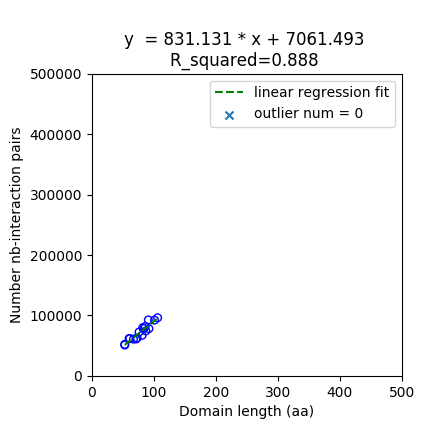

In [30]:
%matplotlib inline
import mpld3
plt.close("all")
siz = [400,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
# fig.tight_layout()

# DPI = fig.get_dpi()
# fig.set_size_inches(400.0/float(DPI),400.0/float(DPI))    

ax1 = fig.add_subplot(111)


pdata = preprocess(sfname);

### preprocess() returns a tuple of shape (nonbonded_pair_nums, DOPE, domain_length,  domian_id)
if not pdata:
    y2s,ys,xs,lbls = preprocess(sfname)
else:
    y2s,ys,xs,lbls = pdata

ax1.set_xlim([0,500])
ax1.set_ylim([0,500E3])
ax1.set_xlabel('Domain length (aa)')
ax1.set_ylabel('Number nb-interaction pairs')


ids=[];
for d in select_homsf(sfname).classification_set.all():
    ids.append((d.domain_set.all()[0].id))

# points = ax1.scatter(xs,y2s,s=33,marker = 'x',)
# points = ax1.scatter(xs,y2s,s=30,marker = 'o',color = 'g')
points = ax1.scatter(xs,y2s,edgecolor = 'b',facecolor = 'none',marker ='o', s =30)

# ((m,b),C) = np.polyfit(xs, y2s, 1, cov =True) ### This covariance seems different from the one generated by np.cov()
(m,b) = np.polyfit(xs, y2s, 1, cov = False)
C = np.cov(xs,y2s)
r_sq = cov2corr(C).flat[1] ** 2

err2  = y2s - ( m*xs + b)
outs = MAD_outlier(err2,3.0)
xso = xs[outs]
y2so = y2s[outs]
ax1.scatter(xso,y2so,s=33,marker = 'x',label='outlier num = %d'%sum(outs))
   
# title = '''
# $y  = %s \\cdot x + %s$ \n
# $R^{2}=%3.3f $'''% (latex_float(m,4),latex_float(b,4),r_sq)

title = '''
y  = %5.3f * x + %5.3f 
R_squared=%3.3f '''% (m,b,r_sq)
xmm = np.array([min(xs),max(xs)])
ax1.plot(xmm, m*xmm + b, 'g--',label = 'linear regression fit')
ax1.legend()

ax1.set_title(
    title)

tooltip = mpld3.plugins.PointLabelTooltip(points, labels=lbls)
mpld3.plugins.connect(fig, tooltip)
mpld3.plugins.connect(fig, HelloWorld(points,ids))
print('r_squared for estimate is ',r_sq)


mpld3.show()
# mpld3.save_json(fig,'tmp')



In [26]:
C=np.cov(xs,y2s)
r_sq = C.flat[1]**2/C.flat[-1]/C.flat[0]
print(r_sq)

0.888284175729


In [28]:
C
np.cov(xs,y2s)

array([[  2.46610294e+02,   2.04965493e+05],
       [  2.04965493e+05,   1.91777819e+08]])

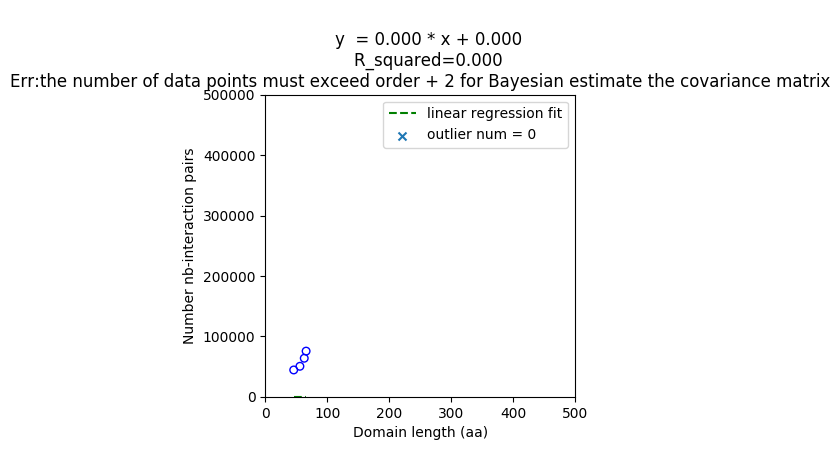

In [60]:
jstr,msg = scatterplot_json('1.10.60.10')

In [48]:
# mpld3.save_json(fig,'tmp')
dct = (mpld3.fig_to_dict(fig))
import json
a  = str(dct) 
b = json.dumps(dct)
[x==y for x,y in zip(a,b)]
# a
# b

'{"axes": [{"xlim": [0.0, 500.0], "yscale": "linear", "axesbg": "#FFFFFF", "texts": [{"v_baseline": "hanging", "h_anchor": "middle", "color": "#000000", "text": "Domain length (aa)", "coordinates": "axes", "zorder": 3, "alpha": 1, "fontsize": 10.0, "position": [0.5, -0.096946284032376762], "rotation": -0.0, "id": "el24824139640014524304"}, {"v_baseline": "auto", "h_anchor": "middle", "color": "#000000", "text": "Number nb-interaction pairs", "coordinates": "axes", "zorder": 3, "alpha": 1, "fontsize": 10.0, "position": [-0.21904121863799283, 0.5], "rotation": -90.0, "id": "el24824139639961763600"}, {"v_baseline": "auto", "h_anchor": "middle", "color": "#000000", "text": "\\ny  = 831.131 * x + 7061.493 \\nR_squared=0.963 ", "coordinates": "axes", "zorder": 3, "alpha": 1, "fontsize": 12.0, "position": [0.5, 1.0275938189845475], "rotation": -0.0, "id": "el24824139640014188368"}, {"v_baseline": "auto", "h_anchor": "start", "color": "#000000", "text": "linear regression fit", "coordinates": 


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [24/Jul/2017 14:47:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Jul/2017 14:47:19] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Jul/2017 14:47:19] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


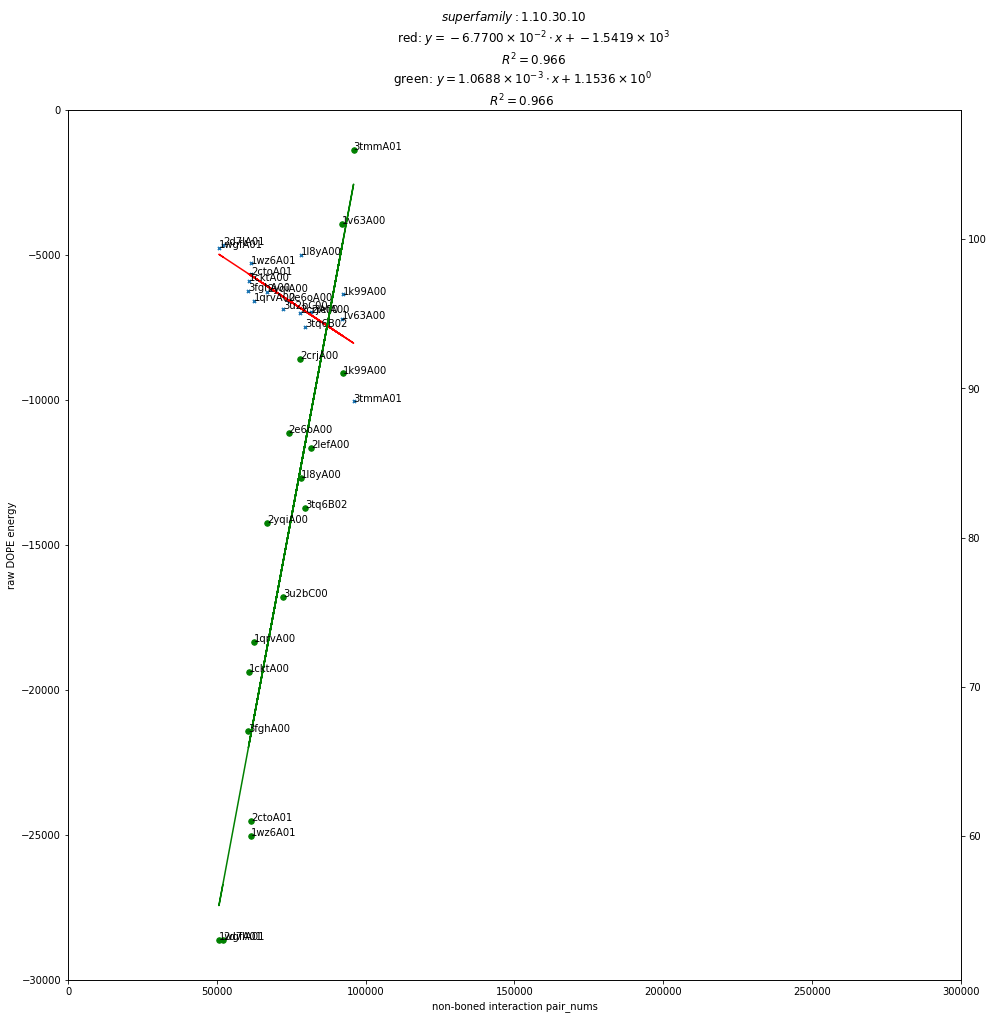

In [13]:
import mpld3
# from mpld3 import
# labels = ['point {0}'.format(i + 1) for i in range(N)]
# labels = 
sfname = "1.10.30.10"
(fig,points) = scatter_p1(sfname)
labels=[];
for d in select_homsf(sfname).classification_set.all():
    labels.append(str(d.id))

tooltip = mpld3.plugins.PointLabelTooltip(points, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.plugins.connect(fig, HelloWorld(points,labels))
mpld3.show()

In [14]:
# sflist = [];
labels=[];
for d in select_homsf(sfname).classification_set.all():
    labels.append(str(d.id))
labels
#         print(d.id)

['276348',
 '276349',
 '276350',
 '276351',
 '276352',
 '276353',
 '276354',
 '276355',
 '276356',
 '276357',
 '276358',
 '276359',
 '276360',
 '276361',
 '276362',
 '276363',
 '276364']

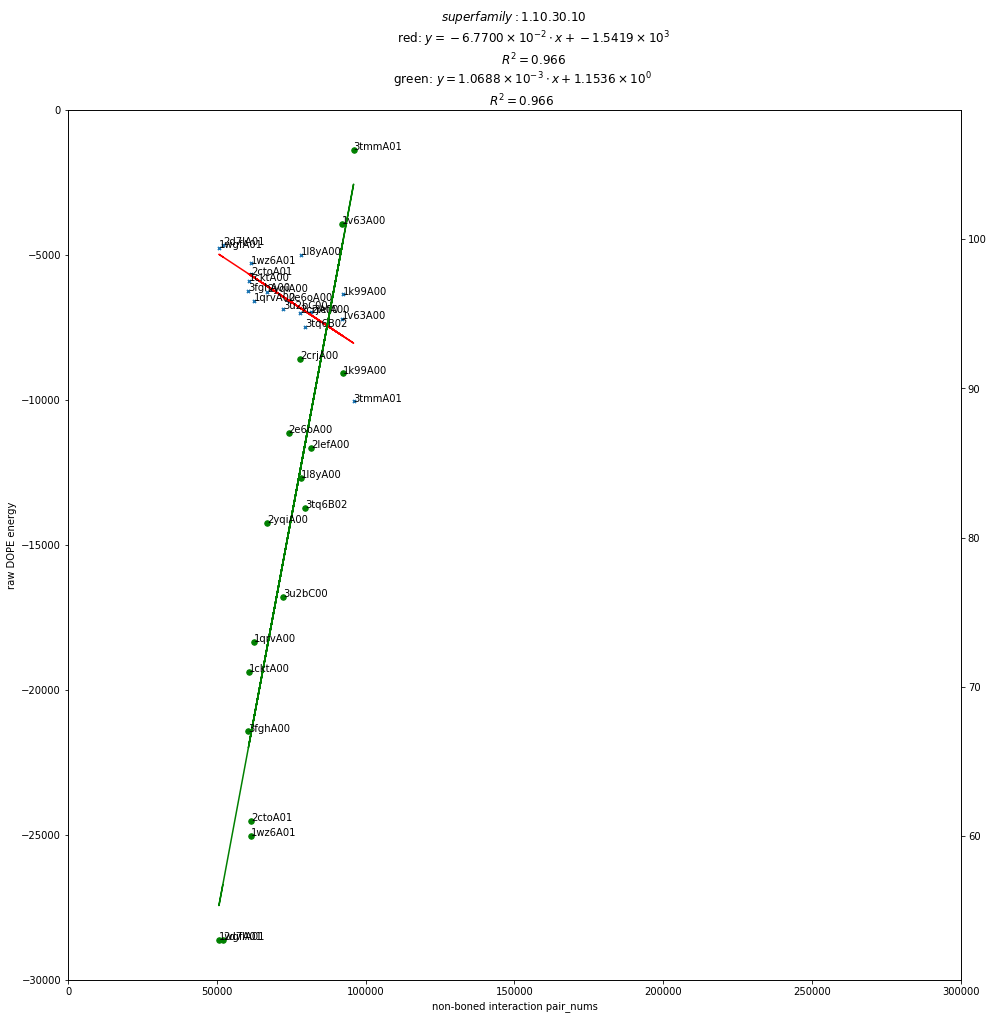

In [15]:
# sfname = "1.10.30.10"
(fig,points) = scatter_p1(sfname)


In [16]:
# fg.__dict__
fg.callbacks

NameError: name 'fg' is not defined

In [ ]:
sfname = "2.40.50.140"
scatter_p1(sfname)


In [ ]:
sfname = "2.40.50.140"
sfname = "1.10.238.10";
scatter_p1(sfname)

In [ ]:
sfname = "2.40.50.140"
sfname = "1.10.238.10";
sfname = "1.10.10.60"
scatter_p1(sfname)

In [ ]:
sfname = "2.40.50.140"
sfname = "1.10.238.10";
sfname = "1.10.10.60"
sfname = "1.10.10.10"
scatter_p1(sfname)

In [ ]:
sfname = "2.40.50.140"
sfname = "1.10.238.10";
sfname = "1.10.10.60"
sfname = "1.10.10.10"
sfname = "2.40.10.10"
scatter_p1(sfname)

In [ ]:
sfname = "2.40.50.140"
sfname = "1.10.238.10";
sfname = "1.10.10.60"
sfname = "1.10.10.10"
sfname = "2.40.10.10"
sfname = "2.30.30.40"#

scatter_p1(sfname)

In [ ]:
sfname = "2.40.50.140"
sfname = "1.10.238.10";
sfname = "1.10.10.60"
sfname = "1.10.10.10"
sfname = "2.40.10.10"
sfname = "2.30.30.40"#
sfname = "3.30.70.330"
scatter_p1(sfname)

In [ ]:
sfname = "2.40.50.140"
sfname = "1.10.238.10";
sfname = "1.10.10.60"
sfname = "1.10.10.10"
sfname = "2.40.10.10"
sfname = "2.30.30.40"#
sfname = "3.30.70.330"
sfname = "3.10.20.90"
scatter_p1(sfname)

In [ ]:
sflist = [
    "2.40.50.140",
"1.10.238.10",
"1.10.10.60",
"1.10.10.10",
"2.40.10.10",
"2.30.30.40",
"3.30.70.330",
"3.10.20.90",]




# sfname = "2.40.10.10"
# sfname  ="3.30.70.330"
# sfname = "3.10.20.90"
# sfname = "2.30.30.40"
# sfname = "2.40.50.140"
sfname = "1.10.10.10"
# sfname = "1.10.10.60"
# sfname = "1.10.238.10";

pdata = preprocess(sfname)
xs,ys,y2s,lbs= pdata

In [ ]:
C

In [ ]:
# ((m2,m1,b),C) = np.polyfit(xs, y2s, 2, cov =True)
np.polyfit(xs, y2s, 2, cov =True)
# C


In [ ]:
outs = is_outlier(err)

In [ ]:
plt.close("all")
fig = plt.figure(figsize = [20,20])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

# outlier = 0;
outlier = 1;

ax1b = ax1.twinx()
# ax1.set_xlim([1,300e3])
# ax1.set_ylim([-30e3,-1])    
ax1.set_xlabel('non-boned interaction pair_nums')
ax1.set_ylabel('raw DOPE energy') 

# if not pdata:
#     xs,ys,y2s,lbls = preprocess(sfname)
# else:
xs,ys,y2s,lbls = pdata
# xs = np.log10(xs)
# y2s = np.log10(y2s)
#     ys = -ys    xso = xs[outs]
#     y2so = y2s[outs]

# xs
ax1.scatter(xs,ys,s=10,marker = 'x',)
ax1b.scatter(xs,y2s,s=10,marker = 'o',color = 'g')



# for x,y,label in zip(xs,ys,lbls):
#     ax1.annotate(label,xy=(x,y))
# for x,y,label in zip(xs,y2s,lbls):
#     ax1b.annotate(label,xy=(x,y))

((m,b),C) = np.polyfit(xs, ys, 1, cov =True)
r_sq = cov2corr(C).flat[1] ** 2

title = r'''$ superfamily: %s $ 
      red: $y  = %s \cdot x + %s $
      $R^{2}=%3.3f $'''% (sfname,latex_float(m,4),latex_float(b,4),r_sq)
# ax1.plot(x, y, '.')
ax1.plot(xs, m*xs + b, 'r-')


((m,b),C) = np.polyfit(xs, y2s, 1, cov =True)
r_sq = C.flat[1]**2/(C.flat[0]*C.flat[-1])
# r_sq = cov2corr(C).flat[1] ** 2
title += r'''
green: $y  = %s \cdot x + %s $
$R^{2}=%3.3f $'''% (latex_float(m,4),latex_float(b,4),r_sq)
y2s_fit  = m*xs + b
ax1b.plot(xs, y2s_fit, 'g-')
ax3.scatter( y2s_fit, y2s-y2s_fit )

ax1.set_title(
    title)

err2  = y2s - ( m*xs + b)

ax2.hist(err2,20,
         alpha = 0.5,)
         

outs = is_outlier(err2,2.5)

if outlier :    
    xso = xs[outs]
    y2so = y2s[outs]
    ax1b.scatter(xso,y2so,color = 'r',marker ='x', s =50)

for lbl,out,err,y2 in zip(lbls,outs,err2,y2s.flat):
    if out:
        print lbl,err,y2

# # idx = np.where(xs < 1.5E5)and np.where( xs >7E4) and np.where(y2s<125);
# # xs = xs[idx];
# # y2s = y2s[idx];
((m2,m1,b),C) = np.polyfit(y2s, xs, 2, cov =True)
xs_fitted  = np.power(y2s,2)*m2+m1*y2s+b
# ax1b.scatter(xs_fitted,y2s,color = 'b')

print 'square fitting'
err2  = xs - xs_fitted

# ax2.hist(err2,20,
#          alpha = 0.5,)
outs = is_outlier(err2,3.0)
if outlier :
    xso = xs[outs]
    y2so = y2s[outs]
    ax1b.scatter(xso,y2so,edgecolor = 'b',facecolor = 'none',marker ='o', s =50)

for lbl,out,err,y2 in zip(lbls,outs,err2,y2s.flat):
    if out:
        print lbl,err,y2


In [ ]:
# list(y2s.flat)

In [ ]:
sum(outs)

In [ ]:
xs,ys,y2s,lbls = pdata
((m,b),C) = np.polyfit(xs, y2s, 1, cov =True)
r_sq = C.flat[1]**2/(C.flat[0]*C.flat[-1])



In [ ]:
scatter_p1(sfname,[xs,ys,y2s,lbs])